# Project 5.2 Apply Data Storytelling

## Assignment:
How does one go about creating a data story? You have some pointers from the material you've just gone through, but they’re probably a bit on the abstract side when you’re just getting started. Also, storytelling is an art, so you have to get your imagination going. Here are some pointers to get those creative juices flowing. In the following sections we will work step-by-step to create your first Data Story

Pick a dataset - ideally the dataset for your Capstone. If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere.

Get going by asking the following questions and looking for the answers with some code and plots:

Can you count something interesting?

Can you find some trends (high, low, increase, decrease, anomalies)?

Can you make a bar plot or a histogram?

Can you compare two related quantities?

Can you make a scatterplot?

Can you make a time-series plot?

Having made these plots, what are some insights you get from them? Do you see any correlations? Is there a hypothesis you would like to investigate further? What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story? As you work out this story, what are some other trends/relationships you think will make it more complete?

Submission Requirements: Submit links to a Github repository containing a Jupyter notebook. The notebook should contain:

The questions you asked
The trends you investigated
The resulting visualizations and conclusions.
In case the data set is too large to commit to Github, please include a link to the data set inside the Jupyter notebook.

## Data Description:

We analyze the World Bank's data on **Life expectancy at birth** and **Fertility Rate**:  
https://data.worldbank.org/indicator/SP.DYN.LE00.IN  
https://data.worldbank.org/indicator/SP.DYN.TFRT.IN

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

# Set chart defaults
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [2]:
life_exp_df = pd.read_csv('./Life_exp_API_SP.DYN.LE00.IN_DS2_en_csv_v2_10515254.csv', header=2)
fertility_df = pd.read_csv('./Fert_API_SP.DYN.TFRT.IN_DS2_en_csv_v2_10515901.csv', header=2)

***
# Data Wrangling

In [3]:
# Melt dataframes
life_exp_df_molten = life_exp_df.melt(id_vars=[
    'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Rate')
fertility_df_molten = fertility_df.melt(id_vars=[
    'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Rate')

In [4]:
# Join the tables
LE_fert_df = pd.merge(left=life_exp_df_molten, 
                      right=fertility_df_molten, 
                      left_on=['Country Code','Year'], 
                      right_on=['Country Code', 'Year'],
                      how = 'inner')

# Check to see if all countries match up.
assert len(LE_fert_df[LE_fert_df['Country Name_y'] != LE_fert_df['Country Name_x']]) == 0

# All indicator names match up - use these as value column headings
indicator_name_x = LE_fert_df['Indicator Name_x'].unique()[0]
indicator_name_y = LE_fert_df['Indicator Name_y'].unique()[0]
LE_fert_df = LE_fert_df.rename(columns={
    'Country Name_x':'Country Name', 'Rate_x':indicator_name_x, 'Rate_y':indicator_name_y})

# Drop duplicate columns
LE_fert_df = LE_fert_df.drop(columns=[
    'Country Name_y', 'Indicator Name_x', 'Indicator Code_x', 'Indicator Name_y', 'Indicator Code_y'])

# Drop unusable data
LE_fert_df = LE_fert_df[LE_fert_df['Year'] != 'Unnamed: 63']

# Convert dates to datetime
LE_fert_df['Year'] = pd.to_datetime(LE_fert_df['Year'])

The world bank mixes in AGGREGATE codes (eg. WLD - WORLD) with the INDIVIDUAL countries.
This list shows the valid country codes only: https://irows.ucr.edu/research/tsmstudy/wbcountrycodes.htm

In [5]:
valid_country_df = pd.read_csv('./Valid_country_codes.csv', header=0)
valid_cntry_codes = list(valid_country_df['World Bank Code'].unique())
# Add countries not in the list
valid_cntry_codes.extend([
    'AND','ARE','COD','CHI','CUW','CYM','FSM','MCO','MNE','NRU',
    'IMN','PRI','ROU','SGP','SMR','SRB','SSD','TLS','TUV'])

In [6]:
LE_fert_df.head(3)

,Country Name,Country Code,Year,"Life expectancy at birth, total (years)","Fertility rate, total (births per woman)"
0,Aruba,ABW,1960-01-01,65.662,4.820
1,Afghanistan,AFG,1960-01-01,32.292,7.450
2,Angola,AGO,1960-01-01,33.251,7.478


The data table is now "Tidy"

***
# I. Exploratory Data Analysis

## Questions:
1. Is there a relationship between Life Expectancy (L.E.) and Fertility?
2. Is the relationship strong?
3. What trends can we observe in these measures?
4. How are the various parts of the world perfoming wrt. these measures?

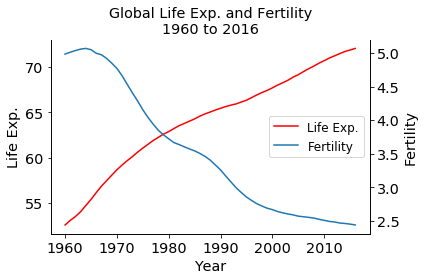

In [15]:
world_data = LE_fert_df[LE_fert_df['Country Name'] == 'World'].sort_values(by='Year', ascending=True)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Life Exp.')
label1, = ax1.plot(world_data['Year'], 
                   world_data['Life expectancy at birth, total (years)'],
                   color ='red',
                   label='Life Exp.')
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()  # Second Y-axis

ax2.set_ylabel('Fertility')
label2, = ax2.plot(world_data['Year'], 
                   world_data['Fertility rate, total (births per woman)'], 
                   label='Fertility')
ax2.spines['top'].set_visible(False)

plt.title('Global Life Exp. and Fertility\n1960 to 2016')
plt.legend(handles=[label1, label2], loc='center right')
plt.autoscale(enable=True, axis='x')
fig.tight_layout()

plt.show()

There is a negative correlation between Life Expectancy and Fertility.

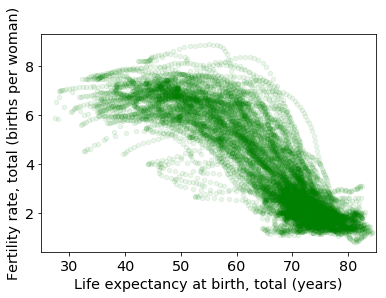

In [8]:
# Scatter all the data
scatter_df = LE_fert_df[LE_fert_df['Country Code'].isin(valid_cntry_codes)][
    ['Life expectancy at birth, total (years)', 'Fertility rate, total (births per woman)']]

scatter_df.plot.scatter(x='Life expectancy at birth, total (years)',
                       y='Fertility rate, total (births per woman)',
                       c='Green', alpha=0.08)

plt.xlim(left=25, right=85)
plt.show()

# EDA Observations

1. There appears to be a strong negative correlation between L.E. and Fertility, regardless of year or country.
2. If the life expectancy in a country is below ca. 50-60yrs, the expected fertility ranges between 6 to 8.
3. Once the life expectancy improves, a sharp drop-off is observed in fertility.  
This continues to about 70yrs. At this point, the fertility rate starts to bottom out at ca. 2 to 4.
4. Once life expectancy exceeds 70 yrs to 75 yrs, fertility rarely exceeds 2.

***
# II. In-depth analysis

1. Determine Pearsons' correlation coefficient between L.E. and Fertility.
2. Determine regression line.
3. Plot the various continents throughout time.

In [9]:
world_data.corr(method='pearson')

,"Life expectancy at birth, total (years)","Fertility rate, total (births per woman)"
"Life expectancy at birth, total (years)",1.000000,-0.977754
"Fertility rate, total (births per woman)",-0.977754,1.000000


1. L.E. and Fertility are nearly perfectly negatively correlated.

In [10]:
# filter out NaNs for polyfit.
idx = np.isfinite(
    scatter_df['Life expectancy at birth, total (years)']) & np.isfinite(
    scatter_df['Fertility rate, total (births per woman)'])
a, b = np.polyfit(x=scatter_df['Life expectancy at birth, total (years)'][idx], 
                  y=scatter_df['Fertility rate, total (births per woman)'][idx], 
                  deg=1)
m, n, o, p  = np.polyfit(x=scatter_df['Life expectancy at birth, total (years)'][idx], 
                         y=scatter_df['Fertility rate, total (births per woman)'][idx], 
                         deg=3)

print("First order regression line: {0:.2f} x + {1:.2f}".format(a, b))
print("Third order Regression line: {0:.2f} x**3 + {1:.2f} x**2 + {2:.2f} x + {3:.2f}".format(m, n, o, p))

First order regression line: -0.15 x + 13.70
Third order Regression line: 0.00 x**3 + -0.02 x**2 + 1.36 x + -17.24


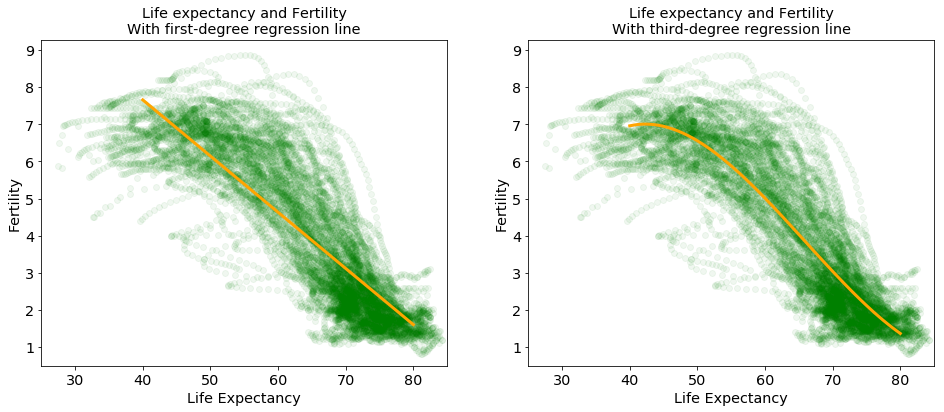

In [11]:
leab = scatter_df['Life expectancy at birth, total (years)']
fert = scatter_df['Fertility rate, total (births per woman)']

X_reg = np.linspace(40, 80, int(max(leab)-min(leab)))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(leab, fert, c='green', alpha=0.06)
plt.plot(X_reg, a*X_reg + b, color='orange', linewidth=3)

plt.title('Life expectancy and Fertility\nWith first-degree regression line')
plt.xlabel('Life Expectancy')
plt.ylabel('Fertility')
plt.xlim(left=25, right=85)
plt.ylim(bottom=0.5)

plt.subplot(1,2,2)
plt.scatter(leab, fert, c='green', alpha=0.06)
plt.plot(X_reg, m*X_reg**3 + n*X_reg**2 + o*X_reg + p, color='orange', linewidth=3)

plt.title('Life expectancy and Fertility\nWith third-degree regression line')
plt.xlabel('Life Expectancy')
plt.ylabel('Fertility')
plt.xlim(left=25, right=85)
plt.ylim(bottom=0.5)
plt.show()

In [12]:
# Determine the slope of the third order regression line at 60.
from sympy import Symbol, Derivative

x = Symbol('x')
deriv = Derivative(m*x**3 + n*x**2 + o*x + p, x)
print('LE of 60:',deriv.doit().subs({x:65}))

LE of 60: -0.199837963630355


2. In general, fertility decreased by 1.5 for every 10 years of L.E. gained between ages 40 and 80.  
3. More specifically, the sharpest decline occurs between 55 and 70 years of life expectancy. Here, fertility decreases by 1 for every 5 to 6 years of life expectancy gained.

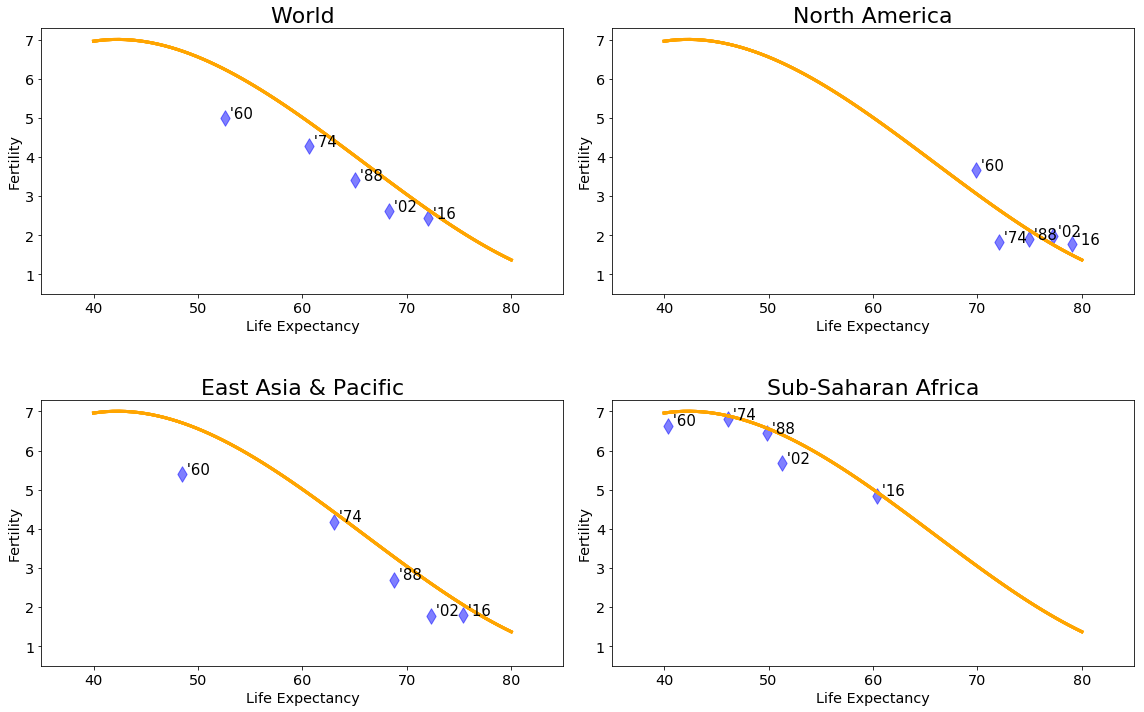

In [14]:
Regions = {4:'Sub-Saharan Africa',3:'East Asia & Pacific', 2:'North America', 1:'World'}
Years = ['2016-01-01', '2002-01-01', '1988-01-01', '1974-01-01', '1960-01-01']

plt.figure(figsize=(16,10))

for k, v in Regions.items():
    for i, yr in enumerate(Years):
        plt.subplot(2,2,k)
        plt.plot(X_reg, m*X_reg**3 + n*X_reg**2 + o*X_reg + p, color='orange', linewidth=3)
        plt.title(v, fontsize=22)
        x = LE_fert_df[(LE_fert_df['Country Name'] == v) & (LE_fert_df['Year'] == yr) ][
                               'Life expectancy at birth, total (years)']
        y = LE_fert_df[(LE_fert_df['Country Name'] == v) & (LE_fert_df['Year'] == yr) ][
                               'Fertility rate, total (births per woman)']
        plt.scatter(x, y, c='blue', marker='d', s=120, alpha=0.5, label=yr[:4])
        plt.annotate(" '"+yr[2:4], (x, y), size=15)
        plt.xlabel('Life Expectancy')
        plt.ylabel('Fertility')
        plt.xlim(left=35, right=85)
        plt.ylim(bottom=0.5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

# Conclusion

Across the world and throughout time, the joint evolution of L.E. and Fertility very closely follows a common curve.  
This is demonstrated very clearly in East Asia and The Pacific, which has tracked almost the entirety of the curve since 1960.  

Sub-Saharan Africa is now well on its way down the curve. They are on the most responsive part of the curve, which is great news.  
Increases in the L.E. now have the largest effect on Fertility.